# Train Low Test Models

This notebook is a streamlined notebook for generating minima of low test accuracy through three different means:
- Dataset Poisoning
- Adding Noise to Data
- Decreasing Dataset Sizes

## Imports

In [1]:
# Standard library
import copy
import os
import sys
import time

# Third-party
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Local package imports
from minima_volume.dataset_funcs import (
    prepare_datasets,
    save_dataset,
    save_model,
)
from minima_volume.train_funcs import evaluate, train

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Input Parameters

In [2]:

# ==============================
# Base Input Parameters
# ==============================
# --- SEEDS ---
data_seed = 10            
model_seed = 0           

# --- Training configuration ---
epochs = 2000            

# --- Dataset configuration ---
base_data_size = 5000
dataset_type = "poison"   
dataset_quantities = [0, 100, 500, 1000, 2000]

# --- Output configuration ---
base_output_dir = ""     
save_generated_dataset = True   
save_generated_models = True    


## Model + Dataset Specific Code

This is for specific code.

In [3]:
# User specifies the CIFAR-10 model module name
from minima_volume.models import CIFAR10_model_data as model_module  # <- your new module for CIFAR-10

# Generate dataset
x_base, y_base, x_test, y_test = model_module.get_dataset(
    device=device
)

# CIFAR-10 MLP initialization parameters
# Since input dimension is higher, hidden layers can be larger
hidden_dims = [512, 256]  # adjust as desired

# Grab model
model_template = model_module.get_model(hidden_dims=hidden_dims, device=device, seed=model_seed)

# Grab loss and metrics
loss_fn = model_module.get_loss_fn()
other_metrics = model_module.get_additional_metrics()

## Training

We generate the various datasets used to train our models here, before training them. We record the losses, and what each model was trained on.

In [4]:
# ==============================
# Prepare datasets
# ==============================
x_base_train, y_base_train, x_additional, y_additional = prepare_datasets(
    x_base=x_base,
    y_base=y_base,
    dataset_type=dataset_type,
    dataset_quantities=dataset_quantities,
    base_data_size=base_data_size,
    data_seed=data_seed,
    seed_1=None,
    seed_2=None,
)

x_base_train = x_base_train.to(device)
y_base_train = y_base_train.to(device)
x_additional = x_additional.to(device)
y_additional = y_additional.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

# ==============================
# Training loop
# ==============================
all_models = []

for additional_data in dataset_quantities:
    # Assemble training dataset
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    # Initialize model (defined in the model-specific file)
    torch.manual_seed(model_seed)
    model = copy.deepcopy(model_template)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3)
    batch_size = len(x_train)

    # Train model
    train_loss, train_other_metrics, test_loss, test_other_metrics = train(
        model = model,
        x_train = x_train, y_train = y_train,
        x_test = x_test, y_test = y_test,
        loss_fn = loss_fn,
        metrics = other_metrics,
        optimizer = optimizer,
        epochs=epochs,
        batch_size=batch_size,
        verbose_every=100,
    )
    
    # Build dictionary dynamically for additional metrics
    train_metrics_dict = {}
    test_metrics_dict = {}
    if train_other_metrics is not None:
        # train_other_metrics is a list of dicts per epoch
        for metric_name in train_other_metrics[0].keys():  # keys from first epoch
            train_metrics_dict[f"train_{metric_name}"] = [m[metric_name] for m in train_other_metrics]
            test_metrics_dict[f"test_{metric_name}"] = [m[metric_name] for m in test_other_metrics]
    
    # Store results
    trained_model = {
        "model": model,
        "train_loss": train_loss,
        "test_loss": test_loss,
        "additional_data": additional_data,
        "dataset_type": dataset_type,
        **train_metrics_dict,  # dynamically include additional metrics
        **test_metrics_dict,
    }
    
    all_models.append(trained_model)

    print(f"Completed training with {additional_data} additional samples of {dataset_type}")

    # Free memory (important for large GPU datasets)
    del x_train, y_train
    torch.cuda.empty_cache()


Epoch 1/2000: Train Loss 2.3122 | Test Loss 2.1154 | accs Train 0.0770 Test 0.2551


Epoch 100/2000: Train Loss 0.0202 | Test Loss 3.0517 | accs Train 1.0000 Test 0.4084


Epoch 200/2000: Train Loss 0.0030 | Test Loss 3.7819 | accs Train 1.0000 Test 0.4089


Epoch 300/2000: Train Loss 0.0013 | Test Loss 4.1193 | accs Train 1.0000 Test 0.4095


Epoch 400/2000: Train Loss 0.0007 | Test Loss 4.3476 | accs Train 1.0000 Test 0.4099


Epoch 500/2000: Train Loss 0.0005 | Test Loss 4.5258 | accs Train 1.0000 Test 0.4098


Epoch 600/2000: Train Loss 0.0003 | Test Loss 4.6735 | accs Train 1.0000 Test 0.4096


Epoch 700/2000: Train Loss 0.0002 | Test Loss 4.7971 | accs Train 1.0000 Test 0.4094


Epoch 800/2000: Train Loss 0.0002 | Test Loss 4.9038 | accs Train 1.0000 Test 0.4094


Epoch 900/2000: Train Loss 0.0001 | Test Loss 4.9961 | accs Train 1.0000 Test 0.4093


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 5.0787 | accs Train 1.0000 Test 0.4097


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 5.1532 | accs Train 1.0000 Test 0.4099


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 5.2216 | accs Train 1.0000 Test 0.4105


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 5.2853 | accs Train 1.0000 Test 0.4098


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 5.3444 | accs Train 1.0000 Test 0.4096


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 5.4000 | accs Train 1.0000 Test 0.4097


Epoch 1600/2000: Train Loss 0.0000 | Test Loss 5.4522 | accs Train 1.0000 Test 0.4097


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 5.5014 | accs Train 1.0000 Test 0.4094


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 5.5487 | accs Train 1.0000 Test 0.4093


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 5.5937 | accs Train 1.0000 Test 0.4093


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 5.6367 | accs Train 1.0000 Test 0.4096
Completed training with 0 additional samples of poison
Epoch 1/2000: Train Loss 2.3121 | Test Loss 2.1155 | accs Train 0.0761 Test 0.2541


Epoch 100/2000: Train Loss 0.0260 | Test Loss 2.9685 | accs Train 1.0000 Test 0.4071


Epoch 200/2000: Train Loss 0.0036 | Test Loss 3.6970 | accs Train 1.0000 Test 0.4051


Epoch 300/2000: Train Loss 0.0016 | Test Loss 4.0364 | accs Train 1.0000 Test 0.4057


Epoch 400/2000: Train Loss 0.0009 | Test Loss 4.2722 | accs Train 1.0000 Test 0.4057


Epoch 500/2000: Train Loss 0.0006 | Test Loss 4.4564 | accs Train 1.0000 Test 0.4054


Epoch 600/2000: Train Loss 0.0004 | Test Loss 4.6107 | accs Train 1.0000 Test 0.4058


Epoch 700/2000: Train Loss 0.0003 | Test Loss 4.7406 | accs Train 1.0000 Test 0.4051


Epoch 800/2000: Train Loss 0.0002 | Test Loss 4.8524 | accs Train 1.0000 Test 0.4048


Epoch 900/2000: Train Loss 0.0002 | Test Loss 4.9511 | accs Train 1.0000 Test 0.4047


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 5.0414 | accs Train 1.0000 Test 0.4044


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 5.1228 | accs Train 1.0000 Test 0.4038


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 5.1966 | accs Train 1.0000 Test 0.4037


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 5.2644 | accs Train 1.0000 Test 0.4036


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 5.3274 | accs Train 1.0000 Test 0.4040


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 5.3869 | accs Train 1.0000 Test 0.4042


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 5.4429 | accs Train 1.0000 Test 0.4046


Epoch 1700/2000: Train Loss 0.0000 | Test Loss 5.4956 | accs Train 1.0000 Test 0.4049


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 5.5456 | accs Train 1.0000 Test 0.4054


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 5.5936 | accs Train 1.0000 Test 0.4058


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 5.6397 | accs Train 1.0000 Test 0.4059
Completed training with 100 additional samples of poison
Epoch 1/2000: Train Loss 2.3118 | Test Loss 2.1163 | accs Train 0.0771 Test 0.2533


Epoch 100/2000: Train Loss 0.0336 | Test Loss 3.0500 | accs Train 1.0000 Test 0.3877


Epoch 200/2000: Train Loss 0.0040 | Test Loss 3.8993 | accs Train 1.0000 Test 0.3820


Epoch 300/2000: Train Loss 0.0016 | Test Loss 4.2682 | accs Train 1.0000 Test 0.3833


Epoch 400/2000: Train Loss 0.0009 | Test Loss 4.5259 | accs Train 1.0000 Test 0.3833


Epoch 500/2000: Train Loss 0.0006 | Test Loss 4.7227 | accs Train 1.0000 Test 0.3821


Epoch 600/2000: Train Loss 0.0004 | Test Loss 4.8811 | accs Train 1.0000 Test 0.3819


Epoch 700/2000: Train Loss 0.0003 | Test Loss 5.0145 | accs Train 1.0000 Test 0.3816


Epoch 800/2000: Train Loss 0.0002 | Test Loss 5.1286 | accs Train 1.0000 Test 0.3817


Epoch 900/2000: Train Loss 0.0002 | Test Loss 5.2291 | accs Train 1.0000 Test 0.3817


Epoch 1000/2000: Train Loss 0.0001 | Test Loss 5.3204 | accs Train 1.0000 Test 0.3819


Epoch 1100/2000: Train Loss 0.0001 | Test Loss 5.4035 | accs Train 1.0000 Test 0.3819


Epoch 1200/2000: Train Loss 0.0001 | Test Loss 5.4798 | accs Train 1.0000 Test 0.3825


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 5.5520 | accs Train 1.0000 Test 0.3823


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 5.6174 | accs Train 1.0000 Test 0.3821


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 5.6785 | accs Train 1.0000 Test 0.3818


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 5.7365 | accs Train 1.0000 Test 0.3816


Epoch 1700/2000: Train Loss 0.0001 | Test Loss 5.7913 | accs Train 1.0000 Test 0.3815


Epoch 1800/2000: Train Loss 0.0000 | Test Loss 5.8430 | accs Train 1.0000 Test 0.3810


Epoch 1900/2000: Train Loss 0.0000 | Test Loss 5.8929 | accs Train 1.0000 Test 0.3806


Epoch 2000/2000: Train Loss 0.0000 | Test Loss 5.9410 | accs Train 1.0000 Test 0.3805
Completed training with 500 additional samples of poison
Epoch 1/2000: Train Loss 2.3111 | Test Loss 2.1179 | accs Train 0.0798 Test 0.2501


Epoch 100/2000: Train Loss 0.0796 | Test Loss 2.7342 | accs Train 0.9978 Test 0.3712


Epoch 200/2000: Train Loss 0.0077 | Test Loss 3.6589 | accs Train 1.0000 Test 0.3696


Epoch 300/2000: Train Loss 0.0029 | Test Loss 4.0914 | accs Train 1.0000 Test 0.3697


Epoch 400/2000: Train Loss 0.0015 | Test Loss 4.3812 | accs Train 1.0000 Test 0.3677


Epoch 500/2000: Train Loss 0.0010 | Test Loss 4.6037 | accs Train 1.0000 Test 0.3669


Epoch 600/2000: Train Loss 0.0007 | Test Loss 4.7863 | accs Train 1.0000 Test 0.3658


Epoch 700/2000: Train Loss 0.0005 | Test Loss 4.9386 | accs Train 1.0000 Test 0.3646


Epoch 800/2000: Train Loss 0.0004 | Test Loss 5.0728 | accs Train 1.0000 Test 0.3650


Epoch 900/2000: Train Loss 0.0003 | Test Loss 5.1931 | accs Train 1.0000 Test 0.3641


Epoch 1000/2000: Train Loss 0.0002 | Test Loss 5.2993 | accs Train 1.0000 Test 0.3644


Epoch 1100/2000: Train Loss 0.0002 | Test Loss 5.3946 | accs Train 1.0000 Test 0.3638


Epoch 1200/2000: Train Loss 0.0002 | Test Loss 5.4810 | accs Train 1.0000 Test 0.3637


Epoch 1300/2000: Train Loss 0.0001 | Test Loss 5.5602 | accs Train 1.0000 Test 0.3639


Epoch 1400/2000: Train Loss 0.0001 | Test Loss 5.6349 | accs Train 1.0000 Test 0.3635


Epoch 1500/2000: Train Loss 0.0001 | Test Loss 5.7045 | accs Train 1.0000 Test 0.3632


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 5.7699 | accs Train 1.0000 Test 0.3631


Epoch 1700/2000: Train Loss 0.0001 | Test Loss 5.8324 | accs Train 1.0000 Test 0.3634


Epoch 1800/2000: Train Loss 0.0001 | Test Loss 5.8919 | accs Train 1.0000 Test 0.3633


Epoch 1900/2000: Train Loss 0.0001 | Test Loss 5.9484 | accs Train 1.0000 Test 0.3631


Epoch 2000/2000: Train Loss 0.0001 | Test Loss 6.0020 | accs Train 1.0000 Test 0.3625
Completed training with 1000 additional samples of poison
Epoch 1/2000: Train Loss 2.3105 | Test Loss 2.1204 | accs Train 0.0843 Test 0.2576


Epoch 100/2000: Train Loss 0.1510 | Test Loss 2.7360 | accs Train 0.9870 Test 0.3317


Epoch 200/2000: Train Loss 0.0117 | Test Loss 3.8001 | accs Train 1.0000 Test 0.3312


Epoch 300/2000: Train Loss 0.0042 | Test Loss 4.2647 | accs Train 1.0000 Test 0.3290


Epoch 400/2000: Train Loss 0.0022 | Test Loss 4.5582 | accs Train 1.0000 Test 0.3278


Epoch 500/2000: Train Loss 0.0014 | Test Loss 4.7790 | accs Train 1.0000 Test 0.3270


Epoch 600/2000: Train Loss 0.0010 | Test Loss 4.9560 | accs Train 1.0000 Test 0.3271


Epoch 700/2000: Train Loss 0.0007 | Test Loss 5.1040 | accs Train 1.0000 Test 0.3278


Epoch 800/2000: Train Loss 0.0005 | Test Loss 5.2310 | accs Train 1.0000 Test 0.3277


Epoch 900/2000: Train Loss 0.0004 | Test Loss 5.3433 | accs Train 1.0000 Test 0.3270


Epoch 1000/2000: Train Loss 0.0003 | Test Loss 5.4440 | accs Train 1.0000 Test 0.3266


Epoch 1100/2000: Train Loss 0.0003 | Test Loss 5.5367 | accs Train 1.0000 Test 0.3261


Epoch 1200/2000: Train Loss 0.0002 | Test Loss 5.6202 | accs Train 1.0000 Test 0.3251


Epoch 1300/2000: Train Loss 0.0002 | Test Loss 5.6975 | accs Train 1.0000 Test 0.3248


Epoch 1400/2000: Train Loss 0.0002 | Test Loss 5.7680 | accs Train 1.0000 Test 0.3252


Epoch 1500/2000: Train Loss 0.0002 | Test Loss 5.8337 | accs Train 1.0000 Test 0.3246


Epoch 1600/2000: Train Loss 0.0001 | Test Loss 5.8954 | accs Train 1.0000 Test 0.3253


Epoch 1700/2000: Train Loss 0.0001 | Test Loss 5.9532 | accs Train 1.0000 Test 0.3250


Epoch 1800/2000: Train Loss 0.0001 | Test Loss 6.0081 | accs Train 1.0000 Test 0.3250


Epoch 1900/2000: Train Loss 0.0001 | Test Loss 6.0610 | accs Train 1.0000 Test 0.3250


Epoch 2000/2000: Train Loss 0.0001 | Test Loss 6.1118 | accs Train 1.0000 Test 0.3246
Completed training with 2000 additional samples of poison


## Training Summary

In [5]:
# ====================================
# Summary of Training Results
# ====================================
print("=== True Generalization ===")
for model_data in all_models:
    model = model_data["model"]
    additional_data = model_data["additional_data"]

    test_loss, test_metrics = evaluate(
        model=model,
        x_test=x_test,
        y_test=y_test,
        loss_fn=loss_fn,
        metrics=other_metrics
    )

    metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in test_metrics.items()])
    print(
        f"{additional_data:>4} samples | "
        f"Test Loss: {test_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
    )

print("\n=== Model Diagnostics by Training Data ===")
for additional_data in dataset_quantities:
    # Build dataset with this many additional samples
    x_train = torch.cat([x_base_train, x_additional[:additional_data]], dim=0)
    y_train = torch.cat([y_base_train, y_additional[:additional_data]], dim=0)

    print(f"\nDataset type: {dataset_type}, additional samples: {additional_data}")

    for model_data in all_models:
        model = model_data["model"]
        model_additional_data = model_data["additional_data"]

        train_loss, train_metrics = evaluate(
            model=model,
            x_test=x_train,
            y_test=y_train,
            loss_fn=loss_fn,
            metrics=other_metrics
        )

        metrics_str = " | ".join([f"{name}: {val:.4f}" for name, val in train_metrics.items()])
        print(
            f" Model {model_additional_data:>4} | "
            f"Train Loss: {train_loss:.4f}" + (f" | {metrics_str}" if metrics_str else "")
        )

    # Free memory if large
    del x_train, y_train
    torch.cuda.empty_cache()

=== True Generalization ===
   0 samples | Test Loss: 5.6367 | accs: 0.4096
 100 samples | Test Loss: 5.6397 | accs: 0.4059
 500 samples | Test Loss: 5.9410 | accs: 0.3805
1000 samples | Test Loss: 6.0020 | accs: 0.3625
2000 samples | Test Loss: 6.1118 | accs: 0.3246

=== Model Diagnostics by Training Data ===

Dataset type: poison, additional samples: 0
 Model    0 | Train Loss: 0.0000 | accs: 1.0000
 Model  100 | Train Loss: 0.0000 | accs: 1.0000
 Model  500 | Train Loss: 0.0000 | accs: 1.0000
 Model 1000 | Train Loss: 0.0000 | accs: 1.0000
 Model 2000 | Train Loss: 0.0001 | accs: 1.0000

Dataset type: poison, additional samples: 100
 Model    0 | Train Loss: 0.3046 | accs: 0.9824
 Model  100 | Train Loss: 0.0000 | accs: 1.0000
 Model  500 | Train Loss: 0.0000 | accs: 1.0000
 Model 1000 | Train Loss: 0.0000 | accs: 1.0000
 Model 2000 | Train Loss: 0.0001 | accs: 1.0000

Dataset type: poison, additional samples: 500
 Model    0 | Train Loss: 1.5387 | accs: 0.9145
 Model  100 | Train L

### Model + Data Specific Verification

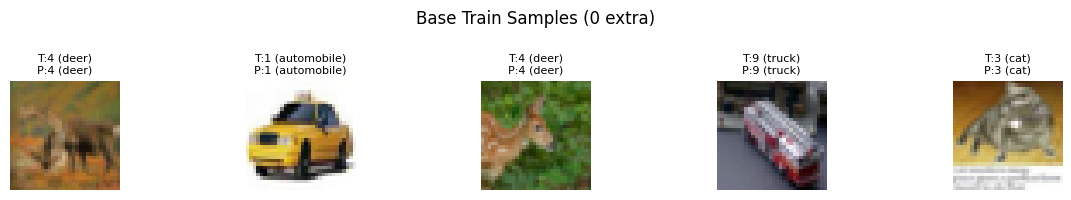

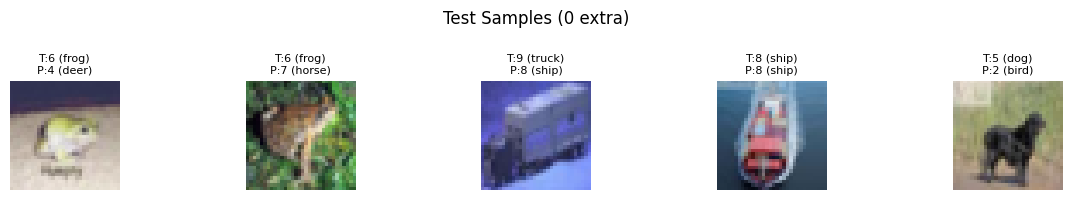

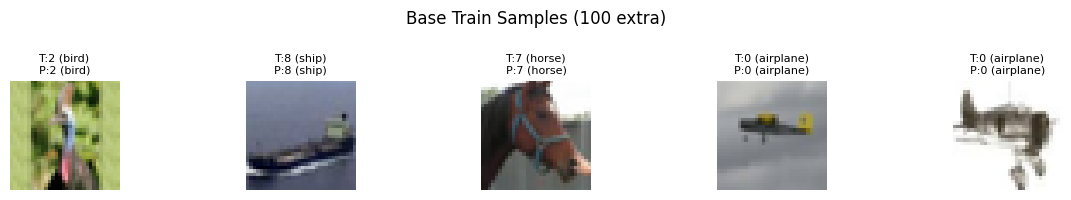

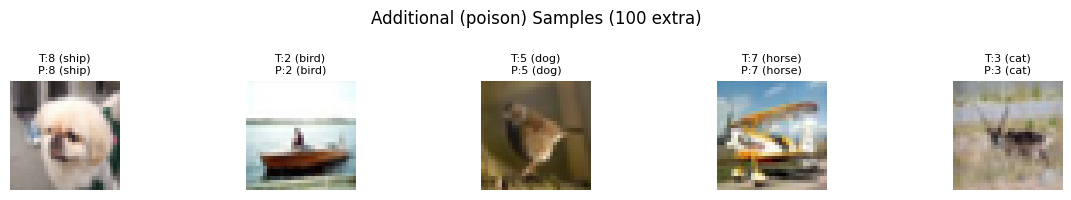

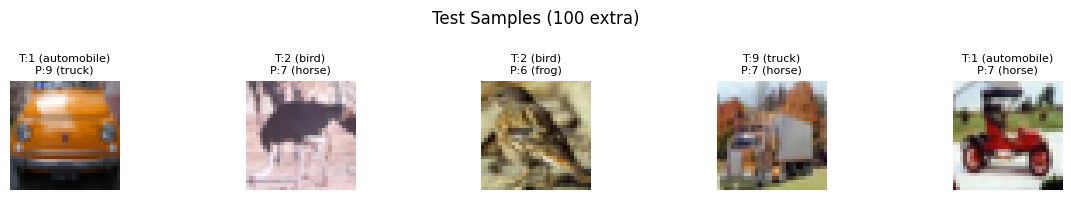

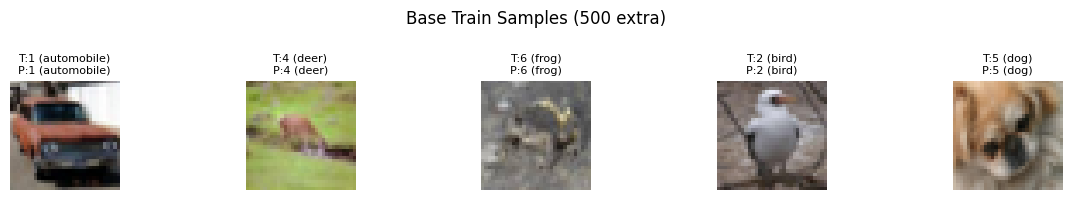

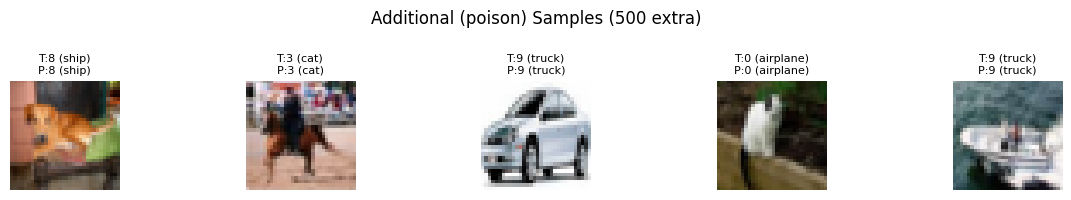

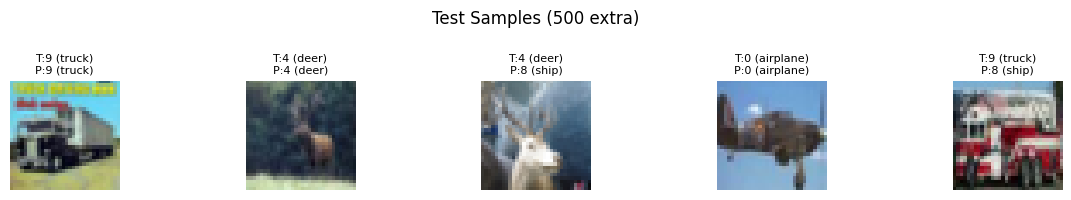

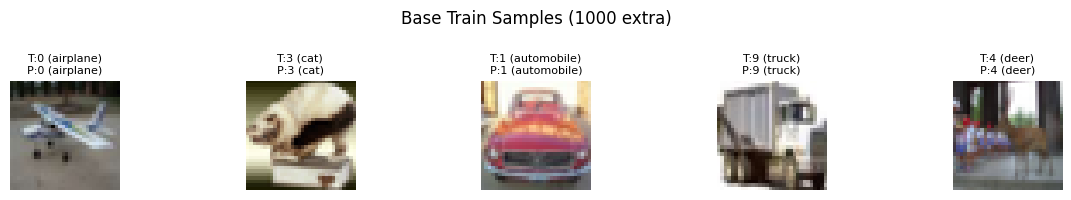

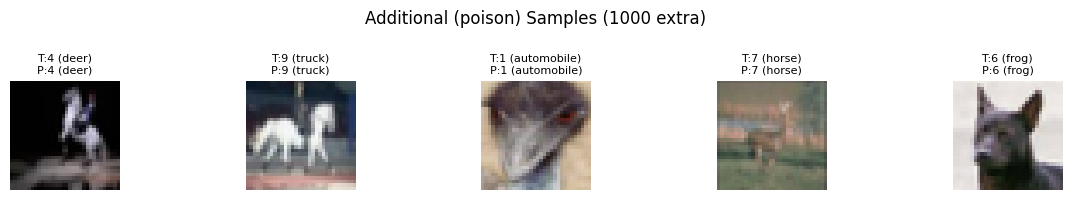

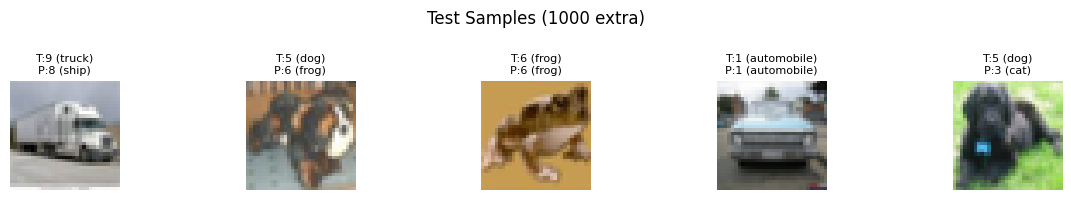

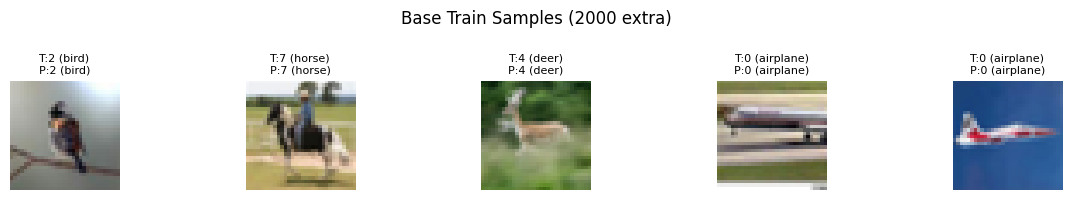

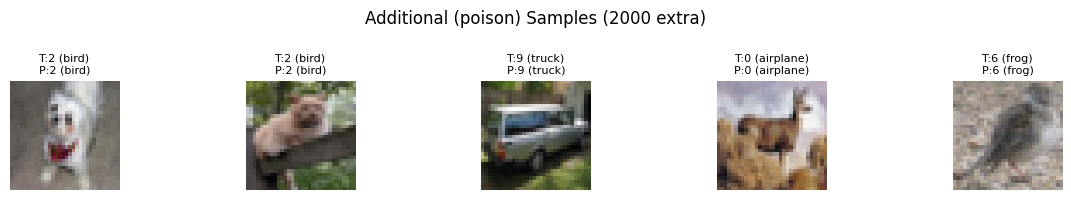

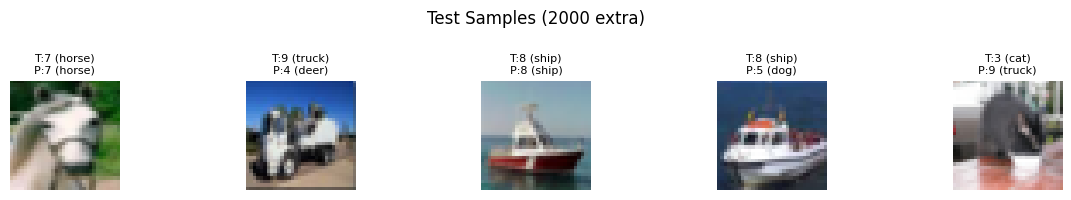

In [6]:
model_module.verify_model_results(
    all_models=all_models,
    x_base_train=x_base_train,
    y_base_train=y_base_train,
    x_additional=x_additional,
    y_additional=y_additional,
    x_test=x_test,
    y_test=y_test,
    dataset_quantities=dataset_quantities,
    dataset_type=dataset_type,
)

## Model Saving

In [7]:
# ====================================
# Save Datasets and Models
# ====================================
output_folder = "models_and_data"
# Save dataset (Possible to skip)
if save_generated_dataset:
    save_dataset(
        folder=output_folder,
        filename="dataset.pt",
        x_base_train=x_base_train,
        y_base_train=y_base_train,
        x_additional=x_additional,
        y_additional=y_additional,
        x_test=x_test,
        y_test=y_test,
        dataset_quantities=dataset_quantities,
        dataset_type=dataset_type,
    )
    print(f"Saved dataset to {output_folder}/dataset.pt")

# Save trained models
if save_generated_models:
    for model_data in all_models:
        filename = f"model_additional_{model_data['additional_data']}.pt"
        save_model(
            folder=output_folder,
            filename=filename,
            model=model_data["model"],
            train_loss=model_data["train_loss"],
            train_accs=model_data["train_accs"],
            test_loss=model_data["test_loss"],
            test_accs=model_data["test_accs"],
            additional_data=model_data["additional_data"],
            dataset_type=model_data["dataset_type"],
        )
        print(f"Saved model: {output_folder}/{filename}")

✅ Dataset saved to models_and_data\dataset.pt
Saved dataset to models_and_data/dataset.pt
✅ Model saved to models_and_data\model_additional_0.pt
Saved model: models_and_data/model_additional_0.pt
✅ Model saved to models_and_data\model_additional_100.pt
Saved model: models_and_data/model_additional_100.pt
✅ Model saved to models_and_data\model_additional_500.pt
Saved model: models_and_data/model_additional_500.pt
✅ Model saved to models_and_data\model_additional_1000.pt
Saved model: models_and_data/model_additional_1000.pt
✅ Model saved to models_and_data\model_additional_2000.pt
Saved model: models_and_data/model_additional_2000.pt
